<a href="https://colab.research.google.com/github/bartoszkozakiewicz/PARAGON_AI_BACKEND/blob/main/ParagonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install paddlepaddle paddleocr
!pip install easyocr
!pip install pyocr
!pip install pytesseract
!apt-get install tesseract-ocr
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.7/465.7 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract

In [6]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb

--2023-10-23 19:08:13--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.83, 185.125.190.39, 91.189.91.81, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321244 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  2.74MB/s    in 0.5s    

2023-10-23 19:08:14 (2.74 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’ saved [1321244/1321244]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 120921 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
debconf: unable to initialize fronten

#1 OCR CONTENT

### 1.1 Prepare image to ocr

- Image to grayscale
- Filter noise
- Detect edges with canny detector

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from google.colab.patches import cv2_imshow

In [ ]:
# Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# Plot image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

Other function to prepare image to OCR

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx


def contour_to_rect(contour,original):
    resize_ratio = 500 / original.shape[0]

    if contour is None:
      print("ZJEBALO SIE COS ")
      return 1

    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255


Get image and prepare for countour detection - pomyslec jeszcze nad kontrast / jasnosc w skrajny czarny i wtedy tak jak w sposobie 2 cos?

In [ ]:
def contours_and_wrap_perspective(closed_image,original,idx):

  #Detect edges with Canny
  edged = cv2.Canny(closed_image, 90, 150, apertureSize=3)
  # plot_gray(edged)

  # Detect all contours in Canny-edged image
  contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  image_with_contours = cv2.drawContours(original.copy(), contours, -1, (0,255,0), 3)
  # plot_rgb(image_with_contours)

  # Get 10 largest contours
  largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
  image_with_largest_contours = cv2.drawContours(original.copy(), largest_contours, -1, (0,255,0), 3)
  plot_rgb(image_with_largest_contours)

  print("Wyodrebnienie jedynie kontorów paragonu",idx)

  #Wyodrebnienie jedynie kontorów paragonu
  receipt_contour = get_receipt_contour(largest_contours)
  # image_with_receipt_contour = cv2.drawContours(original.copy(), [receipt_contour], -1, (0, 255, 0), 2)
  # plot_rgb(image_with_receipt_contour)

  print("Perspektywa lotu ptaka",idx)

  #Perspektywa lotu ptaka
  scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour,original))
  plt.figure(figsize=(16,10))
  # plt.imshow(scanned)
  cv2.imwrite(f"/content/drive/MyDrive/img_kerf_warp_persp/k_wrap{idx}.jpg",scanned)

  print("Przejście na czarno-biały",idx)

  #Przejście na czarno-biały
  result = bw_scanner(scanned)
  cv2.imwrite(f"/content/drive/MyDrive/img_kref_scan/k_scan{idx}.jpg",result)
  plot_gray(result)

Sposob 1 - lepsze rezultaty, ale jak nie wylapie to juz nic nie wezmie

In [ ]:
def img_to_wrap_perspective(image_filepath,idx=1):

  # alpha = 1
  # beta = 10
  image = cv2.imread(image_filepath)
  # image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
  # Downscale image as finding receipt contour is more efficient on a small image
  resize_ratio = 500 / image.shape[0]
  original = image.copy()
  image = opencv_resize(image, resize_ratio)

  cv2_imshow(image)

  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

  # PROGI NA HLS (hue/light/saturation)- WYODRĘBNIENIE BIAŁEGO
  lower_white = np.array([20, 170, 0], dtype=np.uint8)  # Dolny próg - jasność powyżej 200
  upper_white = np.array([172, 255, 255], dtype=np.uint8)  # Górny próg - odcień bliski 0 lub 179, nasycenie poniżej 30, jasność 255
  # Przeprowadź progowanie na obrazie HSV w oparciu o ustawione progi
  white_mask = cv2.inRange(hsv_image, lower_white, upper_white)


  # Przygotuj jądro (kernel) do operacji morfologicznych
  kernel = np.ones((30,30), np.uint8)  # Możesz dostosować rozmiar jądra do wielkości dziur
  # Wykonaj operację zamknięcia, aby wypełnić dziury

  #Najpierw uzupełnij - w razie gdyby na paragonie był jakiś cień
  closed_image = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)

  #Pozniej wyrzucic wszystkie jakies kropki ktore potencjalnie moze zlapac po drodze
  closed_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

  cv2_imshow(closed_image)

  contours_and_wrap_perspective(closed_image,original,idx)


Take file_path to process them

In [ ]:
folder_path = "/content/drive/MyDrive/img_kerf"

file_paths = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


In [ ]:
for idx,file_path in enumerate(file_paths):
  print(idx,"---------------------------------------------")
  img_to_wrap_perspective(file_path)


Sposob 2 - gorsze rezultaty, ale w dobrych warunkach bezpieczniejszy

In [ ]:
def img_to_wrap_perspective2(image_filepath,idx=1):

  image = cv2.imread(image_filepath)

  # Downscale image as finding receipt contour is more efficient on a small image
  resize_ratio = 500 / image.shape[0]
  original = image.copy()
  image = opencv_resize(image, resize_ratio)

  #Change image to gray scale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # plot_gray(gray)

  #Delete noise
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # plot_gray(blurred)

  # Detect white regions
  rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (22,22))
  dilated = cv2.dilate(blurred, rectKernel)
  # plot_gray(dilated)

  contours_and_wrap_perspective(dilated,original,idx)


In [ ]:
for idx,file_path in enumerate(file_paths):
  print(idx,"---------------------------------------------")
  img_to_wrap_perspective2(file_path,idx)

USING EASYOCER TO EXTRACT TEXT FROM PREPARED IMAGE

In [ ]:
import easyocr
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import pandas as pd

reader = easyocr.Reader(['pl'], gpu=True)


path = "/content/drive/MyDrive/img_kref_scan/k_scan0.jpg"
path_wrap = "/content/drive/MyDrive/img_kerf_warp_persp/k_wrap0.jpg"


img = cv2.imread(path)
img_wrap = Image.open(path_wrap)


results = reader.readtext(img, detail=1, paragraph=False) #Set detail to 0 for simple text output , paragraph=False
("---------------------------------------------\n")

prepared_results= []
for idx,result in enumerate(results):
  # print(idx,"BBOX: ",result[0], "TEXT: ",result[1])
  bbox = result[0][0] + result[0][2]
  prepared_results.append({"x0":int(bbox[0]),"y0":int(bbox[1]),"x2":int(bbox[2]),"y2":int(bbox[3]) , "word": result[1]})

pd.DataFrame(prepared_results)

PREPARED RESULTS:  [{'x0': 447, 'y0': 326, 'x2': 893, 'y2': 393, 'word': 'CARREFOUR Polska Sp'}, {'x0': 920, 'y0': 345, 'x2': 946, 'y2': 383, 'word': '2'}, {'x0': 964, 'y0': 342, 'x2': 1012, 'y2': 387, 'word': '0 ,'}, {'x0': 1032, 'y0': 344, 'x2': 1077, 'y2': 384, 'word': '0 .'}, {'x0': 424, 'y0': 385, 'x2': 845, 'y2': 446, 'word': '03-734 Varszava uI.'}, {'x0': 870, 'y0': 382, 'x2': 1111, 'y2': 450, 'word': 'Targow; 72'}, {'x0': 512, 'y0': 441, 'x2': 669, 'y2': 502, 'word': 'Nr rej_'}, {'x0': 692, 'y0': 429, 'x2': 1021, 'y2': 503, 'word': 'BDo: 000009699'}, {'x0': 489, 'y0': 492, 'x2': 1065, 'y2': 561, 'word': "CARREFOUR ' HARKET  Harszava"}, {'x0': 603, 'y0': 549, 'x2': 952, 'y2': 613, 'word': '01-794 Harszawa'}, {'x0': 603, 'y0': 608, 'x2': 932, 'y2': 669, 'word': 'Anny ferman 20'}, {'x0': 580, 'y0': 662, 'x2': 975, 'y2': 726, 'word': 'HIP 937-00-08-168'}, {'x0': 939, 'y0': 719, 'x2': 1399, 'y2': 782, 'word': 'nr Wydr . 364738/0715'}, {'x0': 580, 'y0': 775, 'x2': 952, 'y2': 839, 'wo

,x0,y0,x2,y2,word
0,447,326,893,393,CARREFOUR Polska Sp
1,920,345,946,383,2
2,964,342,1012,387,"0 ,"
3,1032,344,1077,384,0 .
4,424,385,845,446,03-734 Varszava uI.
...,...,...,...,...,...
75,1203,3274,1392,3330,#051.701
76,132,3317,373,3384,2023-09-28
77,1268,3327,1396,3388,"09,46"
78,311,3375,1216,3443,08755029065481C44514848084878E34E5057287


PYTESSERACT OCR - SŁABSZY WYNIK

In [ ]:
import pytesseract
from PIL import Image
path = "/content/drive/MyDrive/img_kref_scan/k_scan0.jpg"
path_wrap = "/content/drive/MyDrive/img_kerf_warp_persp/k_wrap0.jpg"

# Open an image file
img = Image.open(path)
img_wrap = Image.open(path_wrap)

# Perform OCR
text = pytesseract.image_to_string(img)
text_wrap = pytesseract.image_to_string(img_wrap)

# Print the extracted text
print(text)
print("---------------------------------------------")
print("-------------------- TEXT WRAP  -------------------------")
print("---------------------------------------------\")

print(text_wrap)

PARSOWANIE - NIE JESTEM PRZEKONANY

In [ ]:
import pytesseract
from PIL import Image

# Otwórz obraz
img = Image.open(path)

# Ustaw parametry OCR dla trybu hOCR
hocr_text = pytesseract.image_to_pdf_or_hocr(img, extension='hocr')

# Konwertuj wynik do tekstu (HTML)
hocr_text = hocr_text.decode('utf-8')

# Możesz teraz analizować wynik hOCR w formacie HTML
# Przykład ekstrakcji współrzędnych bounding boxów i tekstów
import bs4

soup = bs4.BeautifulSoup(hocr_text, 'html.parser')
for span in soup.find_all('span', class_='ocrx_word'):
    bbox = span['title']  # Współrzędne bounding boxa
    text = span.get_text()  # Tekst

    print(f'BBox: {bbox}, Text: {text}')

PADDLEOCR - NAJLEPSZE WYNIKI

In [ ]:
from paddleocr import PaddleOCR
# Initialize the PaddleOCR reader
ocr = PaddleOCR(use_gpu=True)


In [ ]:
path = "/content/drive/MyDrive/img_kref_scan/k_scan0.jpg"
path_wrap = "/content/drive/MyDrive/img_kerf_warp_persp/k_wrap0.jpg"

# Open an image file
img = Image.open(path)
img_wrap = Image.open(path_wrap)

# Perform text detection and recognition
paddle_results = ocr.ocr(path)
print(paddle_results[0][0])
for idx,result in enumerate(paddle_results[0]):
  # print(idx,"BBOX: ",result[0], "TEXT: ",result[1])
  bbox = result[0][0] + result[0][2]
  prepared_results.append({"x0":int(bbox[0]),"y0":int(bbox[1]),"x2":int(bbox[2]),"y2":int(bbox[3]) , "word": result[1]})
  print("WORD:",result[1],"\n")
# pd.DataFrame(prepared_results)


#Prepare JSON file

In [3]:
from PIL import Image
# json_data = [{
#     "id":
#     "word":,
#     "bboxes":,
#     "label":
#     "num_of_word"
# },]

In [4]:
path = "/content/drive/MyDrive/img_kref_scan/k_scan0.jpg"
img = Image.open(path)


In [7]:
width, height = img.size
print(f"Szerokość: {width}, Wysokość: {height}")

Szerokość: 1540, Wysokość: 3621


In [15]:
import os
folder_path = "/content/drive/MyDrive/img_kref_scan/"
avg_height, avg_width, sum_height,sum_width, num=0,0,0,0,0
# Przejście przez wszystkie pliki w folderze
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        num+=1
        img = Image.open(file_path)
        width, height = img.size
        sum_height += height
        sum_width += width
        print("Plik:", filename,f"Szerokość: {width}, Wysokość: {height}" )
avg_height = sum_height/num
avg_width = sum_width/num
print(f"Średnia Szerokość: {avg_width}, Średnia wysokość: {avg_height}" )


Plik: k_scan0.jpg Szerokość: 1540, Wysokość: 3621
Plik: k_scan1.jpg Szerokość: 1499, Wysokość: 3654
Plik: k_scan2.jpg Szerokość: 1622, Wysokość: 3678
Plik: k_scan4.jpg Szerokość: 1967, Wysokość: 3391
Plik: k_scan5.jpg Szerokość: 2007, Wysokość: 3506
Plik: k_scan6.jpg Szerokość: 2081, Wysokość: 3473
Plik: k_scan8.jpg Szerokość: 1958, Wysokość: 3268
Plik: k_scan9.jpg Szerokość: 1916, Wysokość: 3112
Plik: k_scan10.jpg Szerokość: 2089, Wysokość: 3580
Plik: k_scan11.jpg Szerokość: 1818, Wysokość: 3154
Plik: k_scan12.jpg Szerokość: 1819, Wysokość: 3194
Plik: k_scan13.jpg Szerokość: 1900, Wysokość: 3096
Plik: k_scan14.jpg Szerokość: 1802, Wysokość: 3924
Plik: k_scan15.jpg Szerokość: 1876, Wysokość: 3391
Plik: k_scan16.jpg Szerokość: 2140, Wysokość: 3727
Plik: k_scan17.jpg Szerokość: 1638, Wysokość: 2834
Plik: k_scan18.jpg Szerokość: 1884, Wysokość: 2949
Plik: k_scan19.jpg Szerokość: 2113, Wysokość: 3547
Plik: k_scan20.jpg Szerokość: 1966, Wysokość: 3342
Plik: k_scan21.jpg Szerokość: 2048, Wys

In [18]:
from paddleocr import PaddleOCR
# Initialize the PaddleOCR reader
ocr = PaddleOCR(use_gpu=True)

download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar to /root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer/ch_PP-OCRv4_det_infer.tar


100%|██████████| 4.89M/4.89M [00:14<00:00, 338kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer/ch_PP-OCRv4_rec_infer.tar


100%|██████████| 11.0M/11.0M [00:14<00:00, 733kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:02<00:00, 1.05MiB/s]

[2023/10/23 19:27:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

In [23]:
def data_format_to_label(folder_path):
  data_to_json=[]
  i=0
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
        i+=1
        if i==11:
          break
        paddle_results = ocr.ocr(file_path)
        for idx,result in enumerate(paddle_results[0]):
          data_to_json.append({
            "id":i,
            "word":result[1][0],
            "bboxes":result[0][0] + result[0][2],
            "label":"other",
            "num_of_word":idx
          })

print(data_to_json)

[2023/10/23 19:32:10] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/23 19:32:11] ppocr DEBUG: dt_boxes num : 71, elapsed : 0.5295970439910889
[2023/10/23 19:32:21] ppocr DEBUG: rec_res num  : 71, elapsed : 9.812336444854736
[2023/10/23 19:32:21] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/23 19:32:22] ppocr DEBUG: dt_boxes num : 76, elapsed : 0.7608811855316162
[2023/10/23 19:32:34] ppocr DEBUG: rec_res num  : 76, elapsed : 11.97109866142273
[2023/10/23 19:32:34] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/23 19:32:34] ppocr DEBUG: dt_boxes num : 69, elapsed : 0.5201308727264404
[2023/10/23 19:32:46] ppocr DEBUG: rec_res num  : 69, elapsed : 11.704707384109497
[2023/10/23 19:32:46] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during 

In [ ]:
data_to_json

In [25]:
import json
# Write the data to a JSON file
with open('output.json', 'w') as json_file:
    json.dump(data_to_json, json_file, indent=4)

### Back to finetuning data format

In [31]:
def back_to_end_format(data_to_json):
  data_end_format = {
    "words":[],
    "bboxes":[],
    "labels":[]
  }
  j=1
  for ele in data_to_json:
    if ele["id"] == j:
      j+=1
      data_end_format["words"].append([])
      data_end_format["bboxes"].append([])
      data_end_format["labels"].append([])
    data_end_format["words"][ele["id"]-1].append(ele["word"])
    data_end_format["bboxes"][ele["id"]-1].append(ele["bboxes"])
    data_end_format["labels"][ele["id"]-1].append(ele["label"])
  return data_end_format


{'words': [['CARREFOUR Polska Sp. z 0. 0.', '03-734 Warszawa ul. Targowa 72', 'Nr rej. BD0: 000009699', 'CARREFOUR HARKET WarSzaWa', '01-794 Warszava', 'Anny German 20', 'NIP 937-00-08-168', '.nr wydr. 364738/0715', 'PARAGOH FISKALHY', 'D_MC tOSOS WEDZONY', '1szt*17,99= 17,99 D', 'D_NC WAFLE 100G RYZ', '1szt*2,05= 2,05 D', 'D_SER FAUITA MLEKOU', '1szt*5,69= 5,69 D', 'D_MC TRUSKAUKI POLS', '1szt*11,99= 11,99 D', 'A_NAPOJ COCA COLA 0', '1szt*4,39= 4,39 A', 'D_MC SZPINAK MYTY 2', '2szt*5,99= 11,98 D', 'D_PUDDING PROT.UALI', '1szt*4,99= 4,99 D', 'D_BAJGIEL Z MAKIEM', '1szt*2,69= 2,69 D', 'Sprzed. opod. PTU.A', '4.39', 'Sprzed. opod. PTU D', '57.38', 'Kuota PTU A .23,00%', '0,82', 'Kuota PTU D 00,00%', '0,00', 'SUMA PIU', '0,82', 'SUMA', '61.77', 'PLN', '-.ROZLICZENIE PLATNOSCI', 'Platnosc', '61.77', 'KARTAPLAINI', 'Wptacono razem.', '61,77', '000036/0715', '#051 701', '2023-09-28', '09:46', '564F692FB0CAD74D07F6F5C2F7709335C68D9028', 'ZE EAW1901772707', '00475:0.51.335152309289', 'Kasjer',

In [39]:
print(data_end_format["words"][1])
print("-------------------------")
print(data_end_format["bboxes"][1])
print("-------------------------")
print(data_end_format["labels"][1])
print("-------------------------")
print(len(data_end_format["words"][1]),len(data_end_format["bboxes"][1]),len(data_end_format["labels"][1]))

['CARREFOUR Polska Sp. z O. 0.', '03-734 Warszaua ul. Tar9oua 72', 'Nr rej. BD0: 000009699', 'CARREFOUR MARKET WarSzaua', '01-794 Warszaua', 'Anny Gernan 20', 'NIP 937-00-08-168', 'nr wydr. 280225/0718', 'PARAGON FISKALNY', 'D_NAPOJ B SADOWNICY', '1szt*3,99= 3,99 D', 'D_BRUKSELKA 500 G', '1szt*5,99= 5,99 D', 'D_SEREK TWOJ SMAK 1', '1szt*3,69= 3,69 D', 'B_WEGE CHORIZO 90G', '1szt*13,99= 13,99 B', 'D_SER MANOURI UASSI', '1szt*14,99= 14,99 D', 'D PASTA Z FASOLI SH', '1s2t*7,99= 7,99 D', 'D_NAPOJ INKA IL OUS', '1szt*9,59= 9,59 D', 'D_ROLADKA KOZIA SOI', '1szt*12,49= 12,49 D', 'D_BANANY LUZ', '0,334kg*6,99= 2,33 D', 'D_PARAGWAYO LUZ', '0,17kg*10,99= 1,87 D', 'Sprzed. opod. PTU B', '13,99', 'Sprzed. opod. PTU D', '62,93', 'Kuota PIU B 08,00%', ':1,04', "Kuota PTU D'00,00%", '0,00', 'SUMA PTU', '.1,04', 'SUHA', 'APLN', '76.92', ' ROZLICZENIE PLATNOSCI', 'Ptatnosc', 'KARTAPtATNI- -', '..76,92', 'Uptacono razen', '76,92', '000179/0718', '#052 702', '2023-09-27', ' 21:47', '3ADB458368E757B1B2000

SHOW IMAGE WITH BOUNDING BOXES - FROM EASYOCR

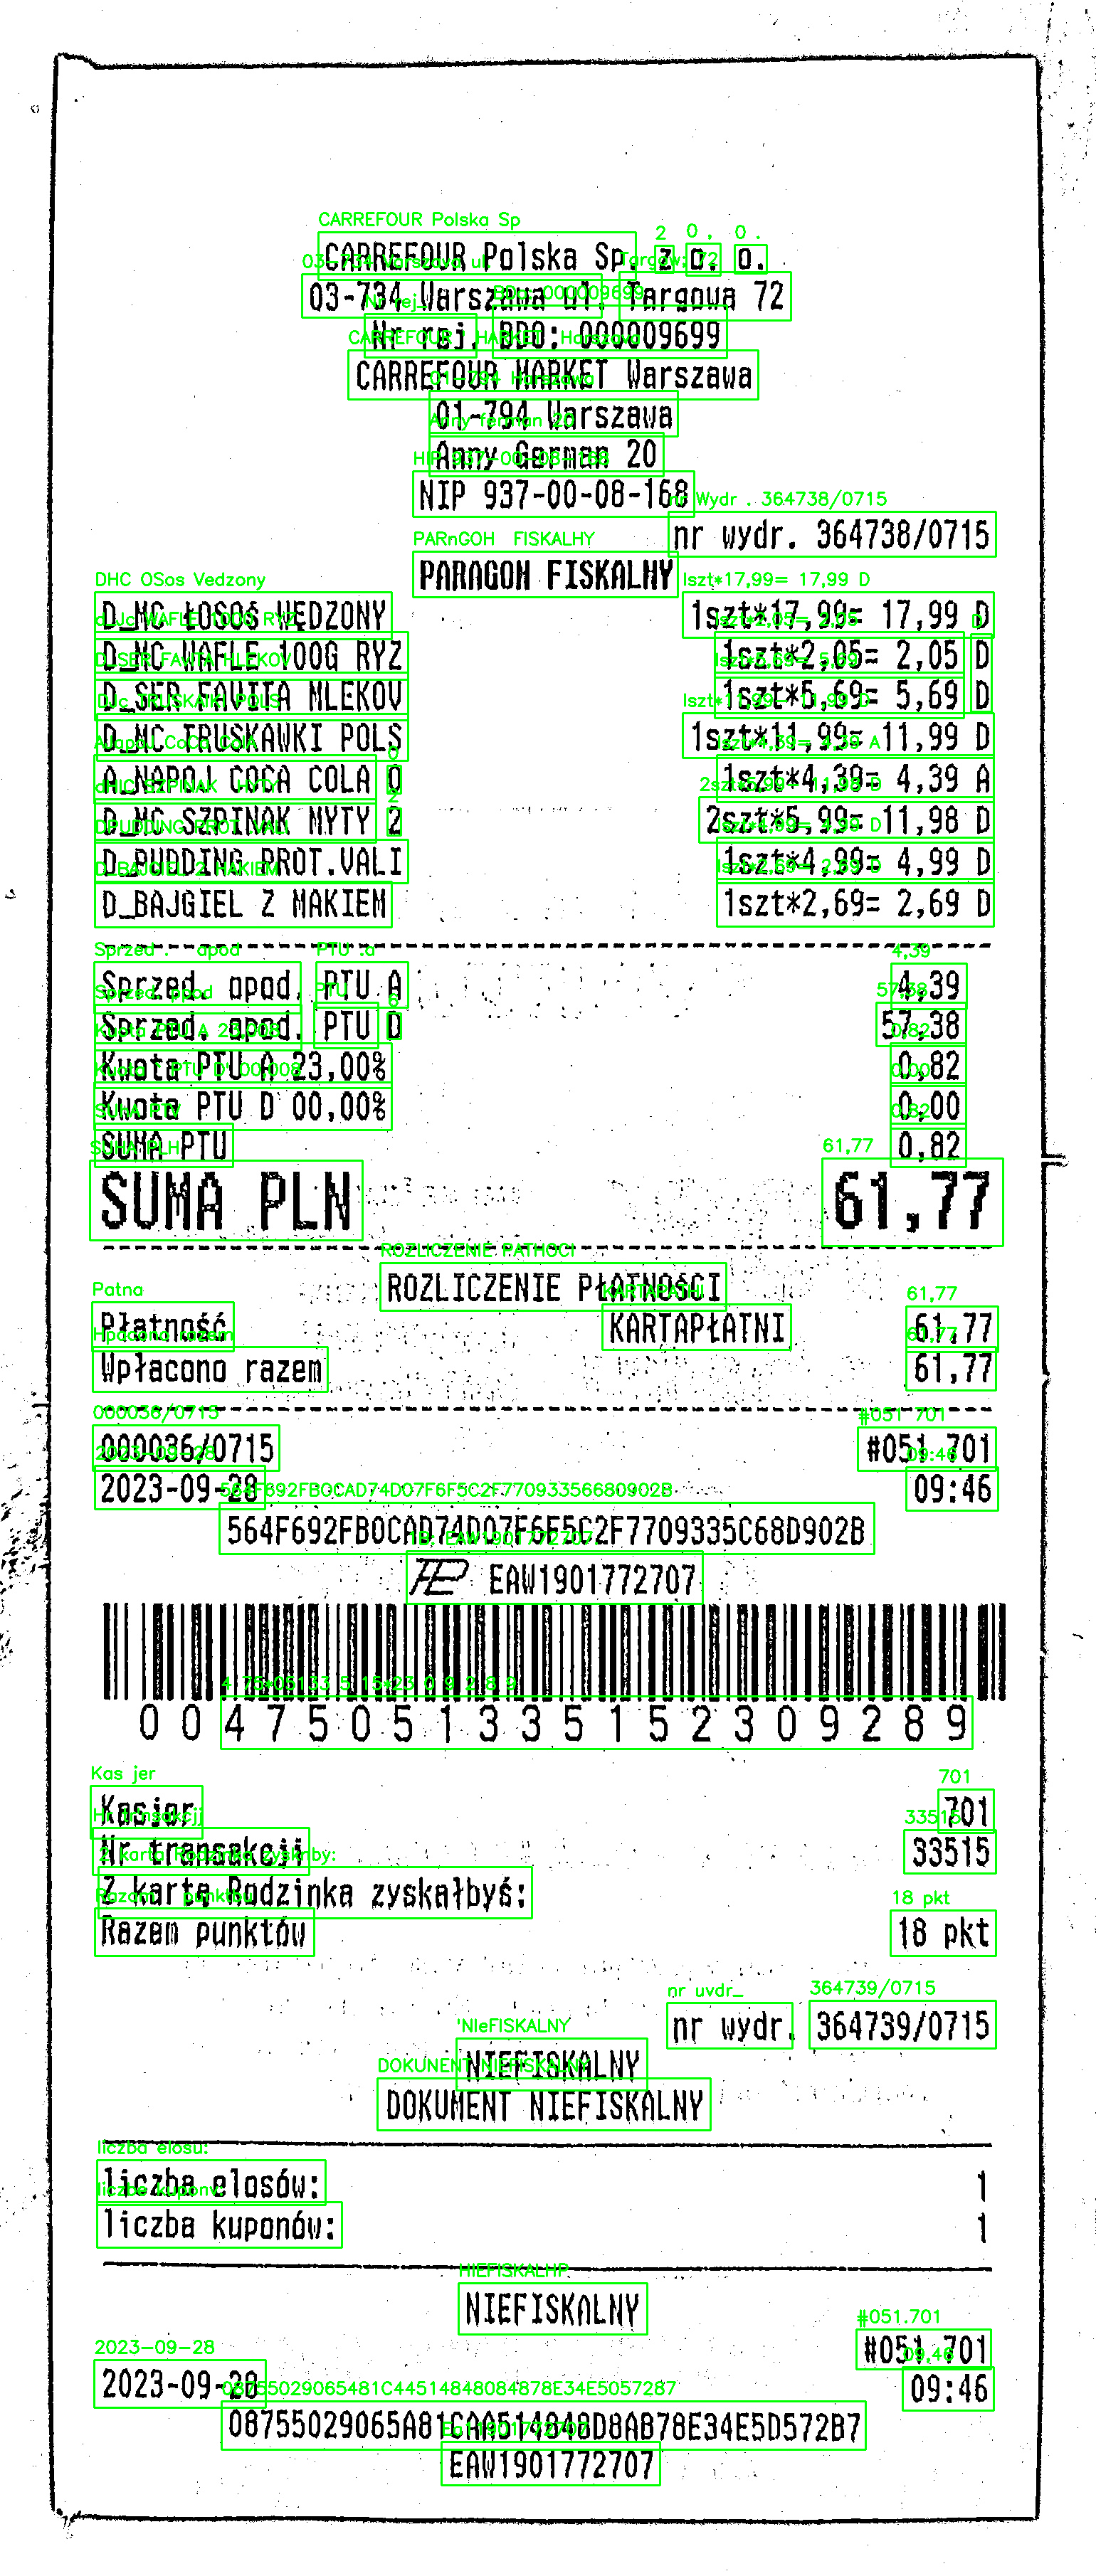

-1

In [ ]:
for (bbox, text, prob) in results:

    #Define bounding boxes
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    #Remove non-ASCII characters to display clean text on the image (using opencv)
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()

    #Put rectangles and text on the image
    cv2.rectangle(img, tl, br, (0, 255, 0), 2)
    cv2.putText(img, text, (tl[0], tl[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
# show the output image
cv2_imshow(img)
cv2.waitKey(0)

# 2 START OF DATA PREPARATION

In [ ]:
import pandas as pd
import numpy as np

prepared_results = []

for idx,result in enumerate(results):
  bbox = result[0][0] + result[0][2]
  prepared_results.append({"x0":int(bbox[0]),"y0":int(bbox[1]),"x2":int(bbox[2]),"y2":int(bbox[3]) , "word": result[1]})

data_to_json = prepared_results
dataframe = pd.DataFrame(prepared_results, dtype=np.int16)
dataframe.head(5)

<ipython-input-6-77bac07d40da>:11: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  dataframe = pd.DataFrame(prepared_results, dtype=np.int16)


,x0,y0,x2,y2,word
0,223,33,265,53,a
1,332,24,380,48,'
2,75,45,113,59,
3,114,39,223,60,6' !
4,111,59,157,75,4-


In [ ]:
import json
# Write the data to a JSON file
with open('output.json', 'w') as json_file:
    json.dump(data_to_json, json_file, indent=4)

# 3 MODEL PREPARATION

### 3.2 Take tokenizers etc from hugginface - MODEL

In [ ]:
from transformers import (
    LayoutLMTokenizer,
)
import torch
from datasets import load_dataset, Features


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = LayoutLMTokenizer.from_pretrained(
   "microsoft/layoutlm-base-uncased",
)

### 3.3 Preprocess data

#### 3.3.1 Normalize bbox

**TEST DATA**

In [ ]:
data = {
    "words":[["a",":","asd","jan"],["a",":","hop","bart","jol"]],
    "bboxes":[[[1133,1286,1657,1366],[728,1350,1283,1448],[1701,1347,2058,1438],[723,1428,1029,1518]],[[933,786,1626,871],[836,840,1804,938],[1078,907,1497,988],[983,968,1559,1054],[925,1046,1007,1119]]],
    "labels":[[1,1,0,2],[0,1,2,2,1]]
}

In [ ]:
from PIL import Image
img_path = "/content/1.jpg"
image = Image.open(name_of_your_document).convert("RGB")

width, height = image.size

def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

In [ ]:
for i,boxes in enumerate(data["bboxes"]):
  for j,box in enumerate(boxes):
    box = normalize_bbox(box, 2500, 2500)
    data["bboxes"][i][j] = box


In [ ]:
data

{'words': [['a', ':', 'asd', 'jan'], ['a', ':', 'hop', 'bart', 'jol']],
 'bboxes': [[[453, 514, 662, 546],
   [291, 540, 513, 579],
   [680, 538, 823, 575],
   [289, 571, 411, 607]],
  [[373, 314, 650, 348],
   [334, 336, 721, 375],
   [431, 362, 598, 395],
   [393, 387, 623, 421],
   [370, 418, 402, 447]]],
 'labels': [[1, 1, 0, 2], [0, 1, 2, 2, 1]]}

**END TEST DATA**

#### 3.3.2 Prepare dataset for model to train

In [ ]:
def final_data_preparation(data,max_length=512):
  final_bbox = []
  final_labels = []
  for word,box,label in zip(data["words"],data["bboxes"],data["labels"]):
    tokenized_word = tokenizer.tokenize(word)
    # print("TOK_WORD",tokenized_word)
    #Prepare final bbox
    final_bbox.extend([box]*len(tokenized_word))
    # print("final_bbox",final_bbox)

    #Prepare final labels
    final_labels.append(label)
    # final_labels.extend([-1 for _ in range(len(tokenized_word)-1)]) # ??
    final_labels.extend([label for _ in range(len(tokenized_word)-1)])

  num_special_tokens = 2
  if len(final_bbox) > max_length - num_special_tokens:
    final_bbox = final_bbox[:(max_length-num_special_tokens)]
    final_labels = final_labels[:(max_length-num_special_tokens)]

  #Lastly make usage of special tokens in bbox and labels
  final_bbox =  [[0, 0, 0, 0]] + final_bbox + [[1000, 1000, 1000, 1000]]
  final_labels =  [0] + final_labels + [0]

  #Create encoding to get - input_ids, attention_mask, token_type_ids
  encoding = tokenizer(" ".join(data["words"]),padding="max_length",truncation=True)
  # print("ENCODING",encoding)
  # print("JOIN"," ".join(data["words"]))

  #If sentence was smaller than max_length then it have to be padding added to final_box and final_labels to keep compatibility
  pad_token_box = [0, 0, 0, 0]
  padding_length = max_length - len(tokenizer(' '.join(data["words"]), truncation=True)["input_ids"])
  final_bbox += [pad_token_box] * padding_length
  final_labels += [0] * padding_length


  ## Fill encoding with previously prepared bboxes and labels
  encoding['bboxes'] = final_bbox
  encoding['ner_tags'] = final_labels

  return encoding

#Process of preparing data
data_result=[]
for x in zip(data["words"], data["bboxes"], data["labels"]):
    x = {"words":x[0],"bboxes":x[1],"labels":x[2]}
    data_result.append(final_data_preparation(x))


Get data into torch dataloaders for training purposes

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LayoutLMDataset(Dataset):
    def __init__(self, data_results):#input_ids,bboxes, attention_mask, token_type_ids,labels
        self.data_results = data_results
        # self.input_ids = input_ids
        # self.bboxes=bboxes
        # self.attention_mask = attention_mask
        # self.token_type_ids = token_type_ids
        # self.labels = labels

    def __len__(self):
        return len(self.data_results)

    def __getitem__(self, idx):
        input_id = self.data_results[idx]["input_ids"]
        bbox = self.data_results[idx]["bboxes"]
        attention_mask = self.data_results[idx]["attention_mask"]
        token_type_id = self.data_results[idx]["token_type_ids"]
        label = self.data_results[idx]["ner_tags"]

        return {
            "input_ids": torch.tensor(input_id,dtype=torch.int64).flatten(),
            "bboxes":torch.tensor(bbox,dtype=torch.int64),
            "attention_mask": torch.tensor(attention_mask,dtype=torch.int64).flatten(),
            "token_type_ids":torch.tensor(token_type_id,dtype=torch.int64).flatten(),
            "ner_tags": torch.tensor(label,dtype=torch.int64).flatten()
        }

Prepare dataloader

In [ ]:
lmDataset = LayoutLMDataset(data_result)
dataloader = DataLoader(lmDataset,batch_size=1, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
inputs= batch
inputs

#### 3.3.3 Train/test split

In [ ]:
train_dataloader=dataloader
valid_dataloader=dataloader

#4 TRAINING PROCEDURE

In [ ]:
from tqdm.notebook import tqdm

for batch in tqdm(train_dataloader):
  labels = batch["ner_tags"].to(device).shape
  input_ids=batch["input_ids"].shape
  bbox=batch["bboxes"].shape
  attention_mask=batch["attention_mask"].shape,
  token_type_ids=batch["token_type_ids"].shape,
  # print(batch)

  print(labels,input_ids,bbox,attention_mask,token_type_ids)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1, 512]) torch.Size([1, 512]) torch.Size([1, 512, 4]) (torch.Size([1, 512]),) (torch.Size([1, 512]),)
torch.Size([1, 512]) torch.Size([1, 512]) torch.Size([1, 512, 4]) (torch.Size([1, 512]),) (torch.Size([1, 512]),)


In [ ]:
from tqdm.notebook import tqdm
from transformers import (
    LayoutLMForTokenClassification,
    AdamW
)

model = LayoutLMForTokenClassification.from_pretrained(
    "microsoft/layoutlm-base-uncased",num_labels=3
    )
model.to(device)

optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 5


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    model.train()
    for batch in tqdm(train_dataloader):
        labels = batch["ner_tags"].to(device)
        print("hop",labels.shape)
        outputs = model(
            input_ids=batch["input_ids"].to(device),
            bbox=batch["bboxes"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            token_type_ids=batch["token_type_ids"].to(device),
            labels=labels
        )
        loss = outputs.loss

        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])

    validation_loss = 0.0
    for batch in tqdm(valid_dataloader):
        labels = batch["ner_tags"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bboxes"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            token_type_ids=batch["token_type_ids"].to(device),
            labels=labels
        )
        loss = outputs.loss

        validation_loss += loss.item()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0


  0%|          | 0/2 [00:00<?, ?it/s]

hop torch.Size([1, 512])
hop torch.Size([1, 512])
Training Loss: 1.5572057366371155


  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.5233279019594193
Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

hop torch.Size([1, 512])
hop torch.Size([1, 512])
Training Loss: 0.33896026760339737


  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.1260138489305973
Epoch: 2


  0%|          | 0/2 [00:00<?, ?it/s]

hop torch.Size([1, 512])
hop torch.Size([1, 512])
Training Loss: 0.09857766330242157


  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.06998126953840256
Epoch: 3


  0%|          | 0/2 [00:00<?, ?it/s]

hop torch.Size([1, 512])
hop torch.Size([1, 512])
Training Loss: 0.07112718373537064


  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.05146443285048008
Epoch: 4


  0%|          | 0/2 [00:00<?, ?it/s]

hop torch.Size([1, 512])
hop torch.Size([1, 512])
Training Loss: 0.05023973248898983


  0%|          | 0/2 [00:00<?, ?it/s]

Validation Loss: 0.04788589850068092


In [ ]:
model.save_pretrained('saved_model/')

# 5 MAKING PREDICTIONS (INFERENCE)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMForTokenClassification.from_pretrained("saved_model")
model.to(device);

In [ ]:
labels = []
id2label = {idx: val for idx, val in enumerate(labels)}


In [ ]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

def normalize_bboxes_in_data(img_data):
  for j,box in enumerate(img_data["bboxes"]):
    box = normalize_bbox(box, 2500, 2500)
    img_data["bboxes"][j] = box
  return img_data


### 5.1 Ocr work

In [ ]:
#Ocr progress

# ...

#Data in format:

img_data = {
    "words":["a",":","asd","jan"],
    "bboxes":[[1133,1286,1657,1366],[728,1350,1283,1448],[1701,1347,2058,1438],[723,1428,1029,1518]]
}

#Normalize data
normalized_data = normalize_bboxes_in_data(img_data)


[[453, 514, 662, 546],
 [291, 540, 513, 579],
 [680, 538, 823, 575],
 [289, 571, 411, 607]]

### 5.2 LayoutLM prediction - for single image

In [ ]:
def predict_layoutLM(img_data):
  end_boxes = []
  for word, box in zip(img_data["words"],img_data["bboxes"]):
    tokenized_word = tokenizer.tokenize(word)
    end_boxes.extend([box]*len(tokenized_word))

  end_boxes = [[0,0,0,0]] + end_boxes + [[1000,1000,1000,1000]]

  encoding = tokenizer(" ".join(img_data["words"]), return_tensors="pt")
  end_boxes = torch.tensor([end_boxes]).to(device)

  outputs = model(
    input_ids=encoding["input_ids"].to(device),
    bbox=end_boxes,
    attention_mask=encoding["attention_mask"].to(device),
    token_type_ids=encoding["token_type_ids"].to(device),
  )

  preds = torch.nn.functional.softmax(outputs.logits,dim=2).cpu().detach().numpy()
  preds_idx = preds.argmax(axis=2)[0]

  return preds_idx


predict_layoutLM(normalized_data)

array([0, 0, 0, 0, 0, 0, 0])